In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve

In [2]:
# 1.2 Load dataset
df = pd.read_csv('TEL_CUST_CHURN.csv')

# 1.3 Handle missing values
# Convert 'TotalCharges' to numeric, set errors='coerce' to handle blanks
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Fill missing TotalCharges with 0 or median (optional: median is better)
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

# 1.4 Encode categorical variables
# Encode 'Churn' (target) first
le = LabelEncoder()
df['Churn'] = le.fit_transform(df['Churn'])  # Yes -> 1, No -> 0

# Identify all other categorical columns (object type)
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# Drop 'customerID' if it's there (it’s just an ID, not useful)
if 'customerID' in categorical_cols:
    df.drop('customerID', axis=1, inplace=True)
    categorical_cols.remove('customerID')

# Apply one-hot encoding to all categorical columns
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# 1.5 Standardize numerical columns (MonthlyCharges, TotalCharges)
scaler = StandardScaler()
df[['MonthlyCharges', 'TotalCharges']] = scaler.fit_transform(df[['MonthlyCharges', 'TotalCharges']])

# DONE ✅
print(df.head())

   SeniorCitizen  tenure  MonthlyCharges  TotalCharges  Churn  gender_Male  \
0              0       1       -1.160323     -0.994242      0        False   
1              0      34       -0.259629     -0.173244      0         True   
2              0       2       -0.362660     -0.959674      1         True   
3              0      45       -0.746535     -0.194766      0         True   
4              0       2        0.197365     -0.940470      1        False   

   Partner_Yes  Dependents_Yes  PhoneService_Yes  \
0         True           False             False   
1        False           False              True   
2        False           False              True   
3        False           False             False   
4        False           False              True   

   MultipleLines_No phone service  ...  StreamingTV_No internet service  \
0                            True  ...                            False   
1                           False  ...                            Fa

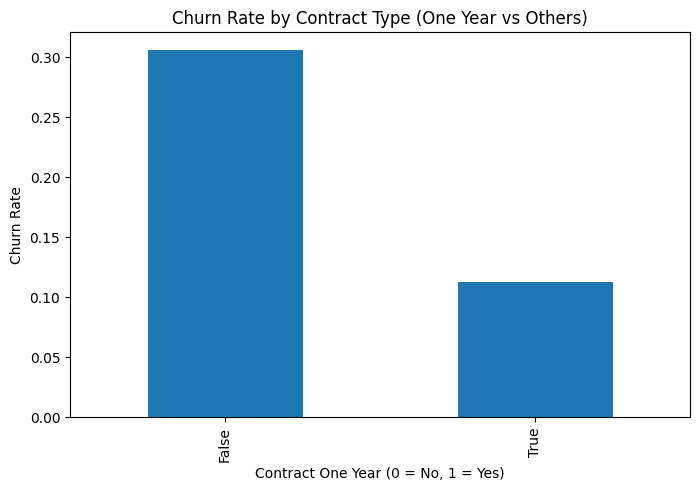

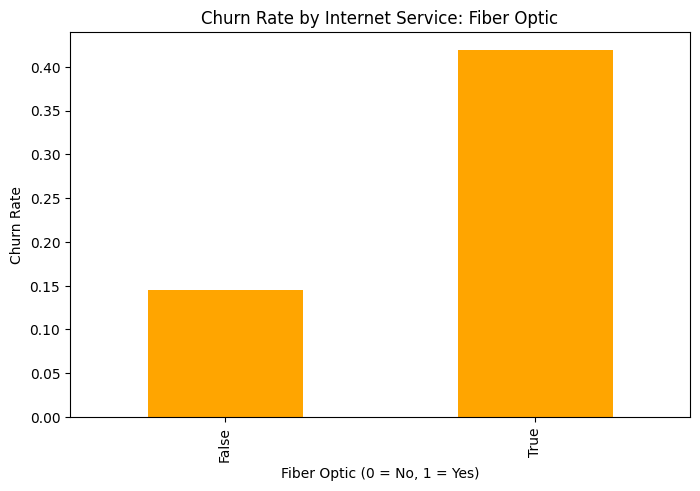

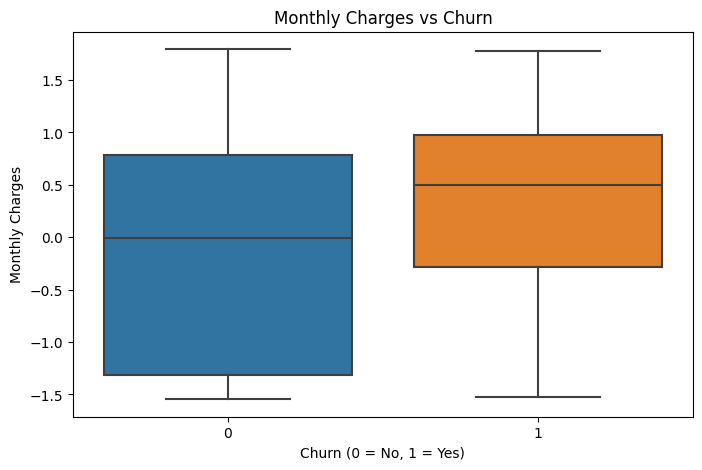

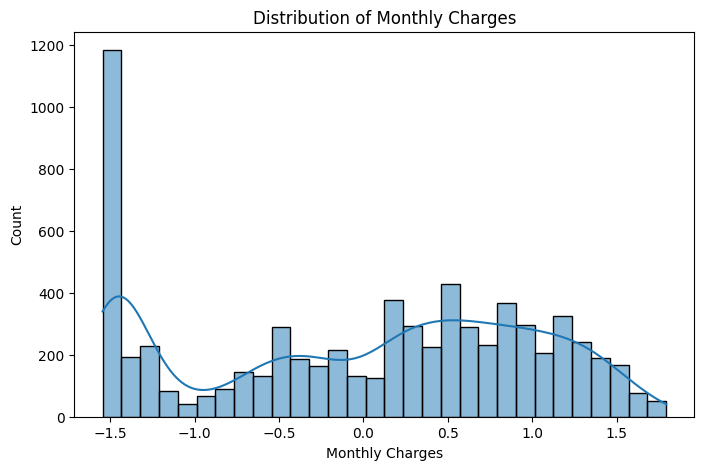

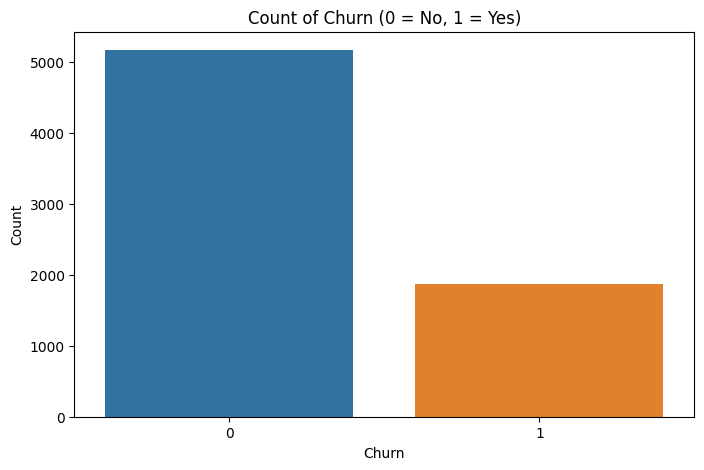

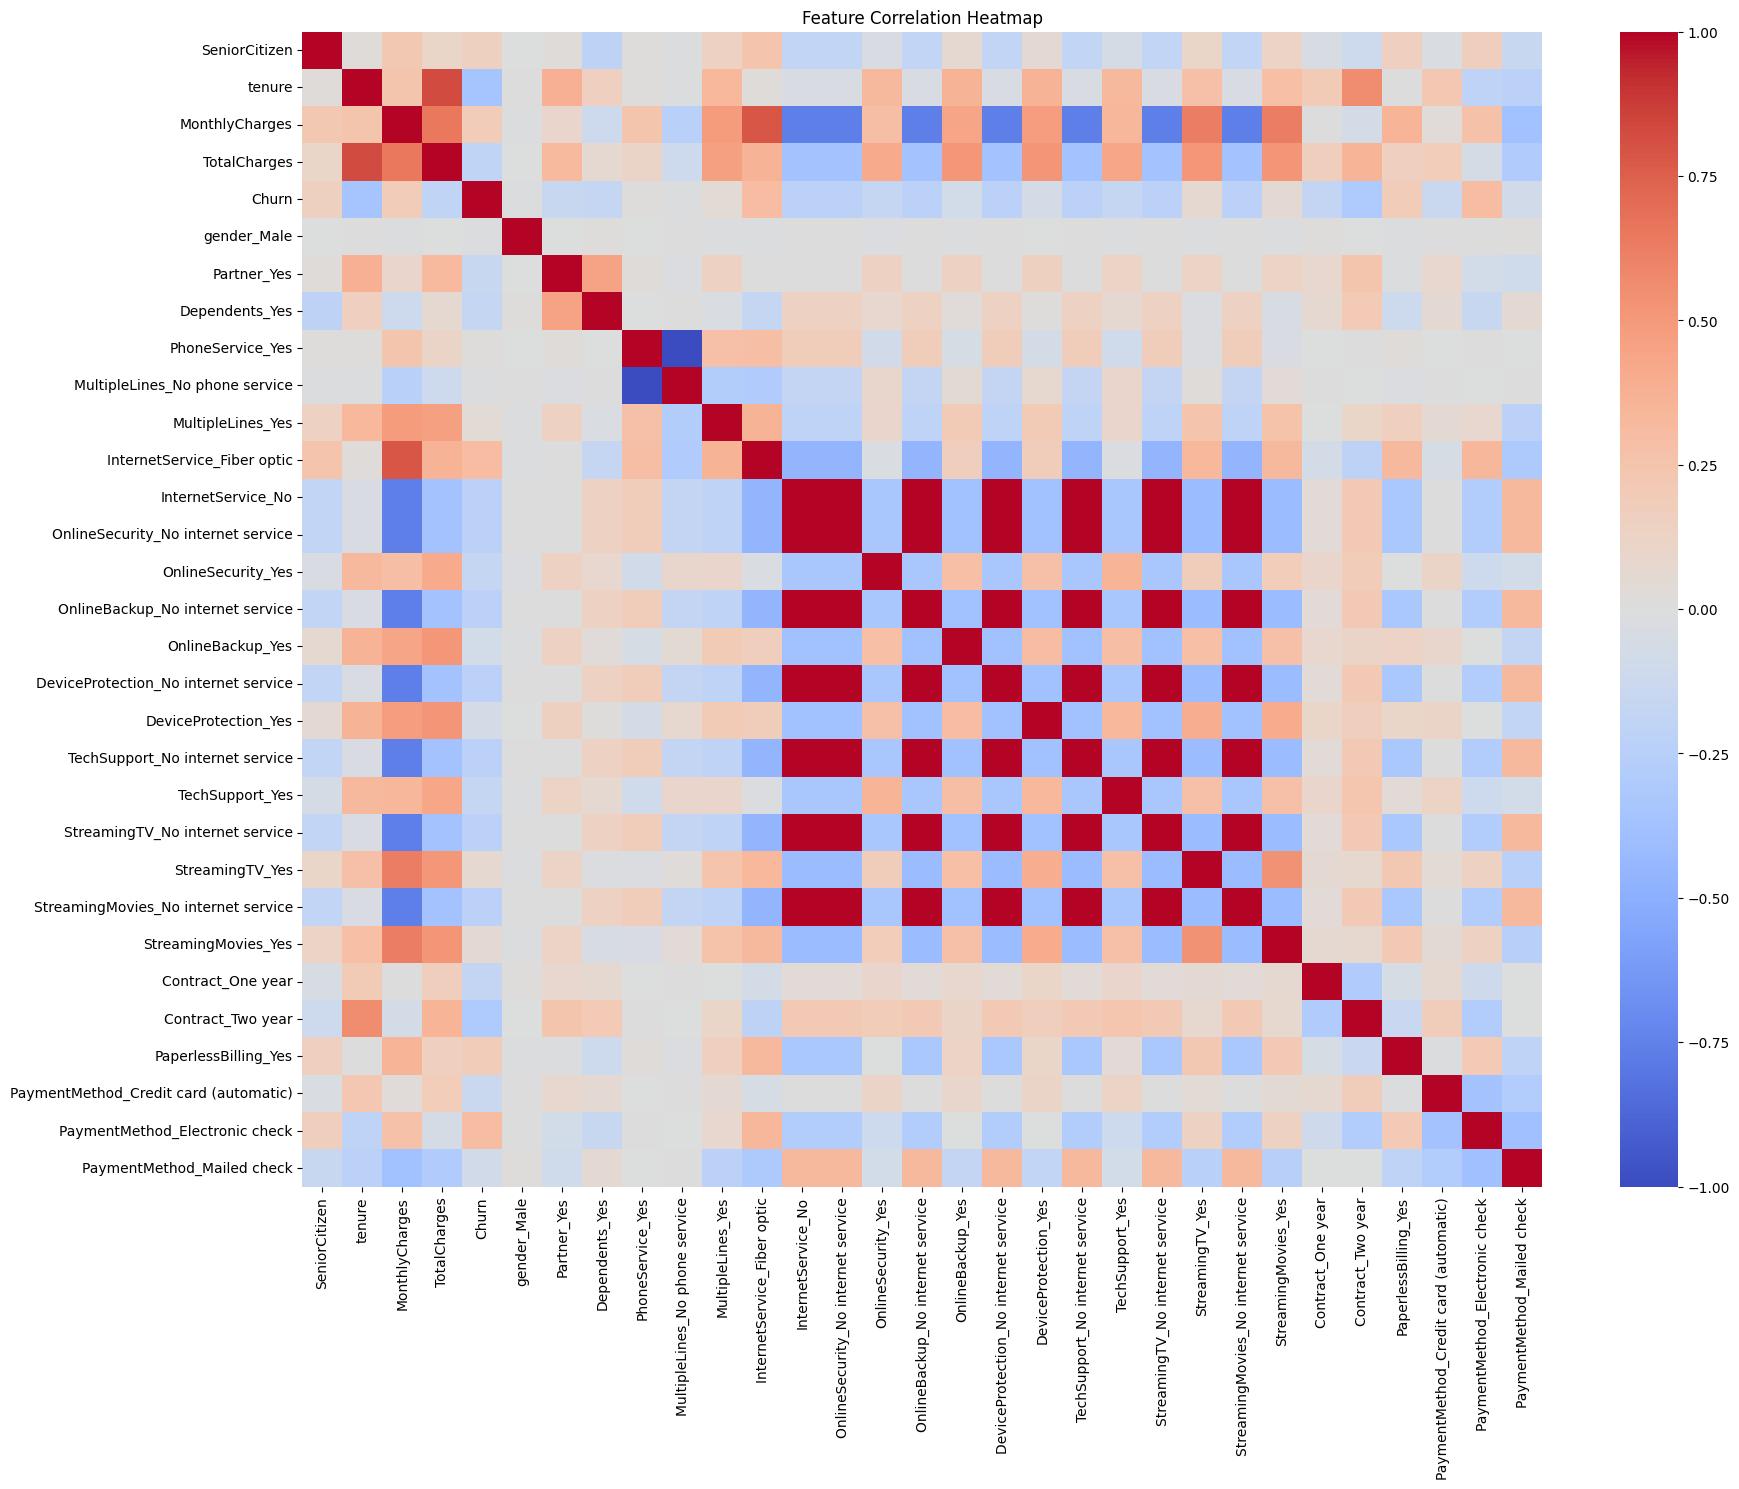

In [3]:
# 2.1 Analyze churn rates by various features

# Example 1: Churn by Contract Type
plt.figure(figsize=(8, 5))
contract_churn = df.groupby('Contract_One year')['Churn'].mean()
contract_churn.plot(kind='bar')
plt.title('Churn Rate by Contract Type (One Year vs Others)')
plt.ylabel('Churn Rate')
plt.xlabel('Contract One Year (0 = No, 1 = Yes)')
plt.show()

# Example 2: Churn by Internet Service Type (Fiber Optic/No)
plt.figure(figsize=(8, 5))
internet_churn = df.groupby('InternetService_Fiber optic')['Churn'].mean()
internet_churn.plot(kind='bar', color='orange')
plt.title('Churn Rate by Internet Service: Fiber Optic')
plt.ylabel('Churn Rate')
plt.xlabel('Fiber Optic (0 = No, 1 = Yes)')
plt.show()

# Example 3: Monthly Charges Distribution by Churn
plt.figure(figsize=(8, 5))
sns.boxplot(x='Churn', y='MonthlyCharges', data=df)
plt.title('Monthly Charges vs Churn')
plt.xlabel('Churn (0 = No, 1 = Yes)')
plt.ylabel('Monthly Charges')
plt.show()

# 2.2 Visualize data using different charts

# Histogram of MonthlyCharges
plt.figure(figsize=(8,5))
sns.histplot(df['MonthlyCharges'], bins=30, kde=True)
plt.title('Distribution of Monthly Charges')
plt.xlabel('Monthly Charges')
plt.ylabel('Count')
plt.show()

# Countplot of Churn
plt.figure(figsize=(8,5))
sns.countplot(x='Churn', data=df)
plt.title('Count of Churn (0 = No, 1 = Yes)')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.show()

# 2.3 Correlation Heatmap

plt.figure(figsize=(20,15))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
plt.title('Feature Correlation Heatmap')
plt.show()

In [4]:
# 3.1 Create a new feature: AverageMonthlySpend
# Handle division by zero (tenure = 0) carefully
df['AverageMonthlySpend'] = df['TotalCharges'] / df['tenure'].replace(0, np.nan)
df['AverageMonthlySpend'].fillna(0, inplace=True)

# 3.2 Remove irrelevant features (if any)
# We already removed 'customerID' earlier.
# Now check if any features are highly correlated (> 0.9)

# Calculate correlation matrix
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.90
high_corr_features = [column for column in upper.columns if any(upper[column] > 0.90)]

# Drop highly correlated features
df.drop(columns=high_corr_features, inplace=True)

print(f"Removed highly correlated features: {high_corr_features}")

# Final check
print(df.shape)
print(df.head())

Removed highly correlated features: ['MultipleLines_No phone service', 'OnlineSecurity_No internet service', 'OnlineBackup_No internet service', 'DeviceProtection_No internet service', 'TechSupport_No internet service', 'StreamingTV_No internet service', 'StreamingMovies_No internet service']
(7043, 25)
   SeniorCitizen  tenure  MonthlyCharges  TotalCharges  Churn  gender_Male  \
0              0       1       -1.160323     -0.994242      0        False   
1              0      34       -0.259629     -0.173244      0         True   
2              0       2       -0.362660     -0.959674      1         True   
3              0      45       -0.746535     -0.194766      0         True   
4              0       2        0.197365     -0.940470      1        False   

   Partner_Yes  Dependents_Yes  PhoneService_Yes  MultipleLines_Yes  ...  \
0         True           False             False              False  ...   
1        False           False              True              False  ...  

In [6]:
# 4.1 Import required libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import shap
import matplotlib.pyplot as plt

# 4.2 Split the dataset
X = df.drop(columns=['Churn'])
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4.3 Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)

# 4.4 Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


# 4.5 Gradient Boosting (XGBoost)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

# 4.6 Cross-validation (optional for tuning performance)
log_reg_cv_score = cross_val_score(log_reg, X, y, cv=5).mean()
rf_cv_score = cross_val_score(rf, X, y, cv=5).mean()
xgb_cv_score = cross_val_score(xgb, X, y, cv=5).mean()

print(f"Logistic Regression CV Score: {log_reg_cv_score:.4f}")
print(f"Random Forest CV Score: {rf_cv_score:.4f}")
print(f"XGBoost CV Score: {xgb_cv_score:.4f}")

Logistic Regression CV Score: 0.8082
Random Forest CV Score: 0.7859
XGBoost CV Score: 0.7799


In [7]:
# Function to print evaluation metrics
def evaluate_model(y_true, y_pred, model_name):
    print(f"\nEvaluation Metrics for {model_name}:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_true, y_pred):.4f}")
    print(f"ROC AUC: {roc_auc_score(y_true, y_pred):.4f}")

# Evaluate Logistic Regression
evaluate_model(y_test, y_pred_log_reg, "Logistic Regression")

# Evaluate Random Forest
evaluate_model(y_test, y_pred_rf, "Random Forest")

# Evaluate XGBoost
evaluate_model(y_test, y_pred_xgb, "XGBoost")


Evaluation Metrics for Logistic Regression:
Accuracy: 0.8169
Precision: 0.6873
Recall: 0.5657
F1 Score: 0.6206
ROC AUC: 0.7365

Evaluation Metrics for Random Forest:
Accuracy: 0.7935
Precision: 0.6541
Recall: 0.4665
F1 Score: 0.5446
ROC AUC: 0.6888

Evaluation Metrics for XGBoost:
Accuracy: 0.7885
Precision: 0.6238
Recall: 0.5067
F1 Score: 0.5592
ROC AUC: 0.6983


In [ ]:
model_columns = X.columns.tolist()

import pickle
with open('model_columns.pkl', 'wb') as f:
    pickle.dump(model_columns, f)

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Plot ROC Curve for all models
def plot_roc(model, X_test, y_test, label_name):
    y_probs = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label_name} (AUC = {roc_auc:.2f})')

plt.figure(figsize=(10, 7))
plot_roc(log_reg, X_test, y_test, "Logistic Regression")
plot_roc(rf, X_test, y_test, "Random Forest")
plot_roc(xgb, X_test, y_test, "XGBoost")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

In [ ]:
# Create an explainer object (example for a tree-based model)
explainer = shap.TreeExplainer(model)  # Replace `model` with your trained model
shap_values = explainer.shap_values(X)  # X is your dataset